In [ ]:
# useful links
# https://stats.idre.ucla.edu/r/dae/zinb/
# https://stats.idre.ucla.edu/stata/output/zero-inflated-negative-binomial-regression/
# https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

#https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html

In [89]:
from __future__ import print_function

# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

# For interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# turn off top and rigt axis line in matplotlib
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# change font size in matplolib
plt.rcParams.update({'font.size': 14})

# increasing the deafult DPI to improve resolution
#plt.rcParams['figure.dpi']= 50 # for preview
plt.rc("savefig", dpi = 300) # for saving

Naming convention for dataframes:

* sd - Secchi disk depth

* t - turbidity

* tss - total suspended solids

* c - chlorophyll

* tcc - total cell count

* tb - total biovolume

* ccc - cyano cell count

* cb - cyano biovolume

In [72]:
# Locate folder with csv for each variable
data_folder = "../../data/processed/regression/"
files = os.listdir(data_folder)

In [73]:
# Check CSV files in the folder
files

['chlorophyll_final.csv',
 'cyano_biovolume_final.csv',
 'cyano_cell_count_final.csv',
 'secchi_depth_final.csv',
 'total_biovolume_final.csv',
 'total_cell_count_final.csv',
 'total_suspended_solids_final.csv',
 'turbidity_final.csv',
 'tweets_daily_final.csv']

In [74]:
# Create a dictionary to hold all the dataframes
df = {}

# Name of dataframe indices - align with the order of files
names = ["c", "cb", "ccc", "sd", "tb", "tcc", "tss", "t", "tweets"]

In [75]:
# Import data
for name, file in zip(names, files):
        df[name] = pd.read_csv(f'{data_folder}{file}')

In [76]:
# Convert date column to datetime object
for file in df.keys():
    # seaprate if statement for tweets dataframe because its date column has a different name
    if file == "tweets":
        df[file]['time'] = pd.to_datetime(df[file]['time'])
    else:
        df[file]["OBJECTID_1"] = pd.to_datetime(df[file]["OBJECTID_1"])
        df[file].columns = df[file].columns.str.replace(".", "")
    

In [77]:
# Merge various tweet count stats with each dataframe

for file in df.keys():

    # Apply following steps in all the dataframes except the one for tweet counts per day
    if file != "tweets":
    
        # create new columns to store tweet counts data

        df[file]['tweets_neg_3_both'] = np.nan
        df[file]['tweets_pos_3_both'] = np.nan
        df[file]['tweets_wq_3_both']  = np.nan 

        df[file]['tweets_neg_3_before'] = np.nan
        df[file]['tweets_pos_3_before'] = np.nan
        df[file]['tweets_wq_3_before']  = np.nan 

        df[file]['tweets_neg_3_after'] = np.nan
        df[file]['tweets_pos_3_after'] = np.nan
        df[file]['tweets_wq_3_after']  = np.nan


        df[file]['tweets_neg_7_both'] = np.nan
        df[file]['tweets_pos_7_both'] = np.nan
        df[file]['tweets_wq_7_both']  = np.nan

        df[file]['tweets_neg_7_before'] = np.nan
        df[file]['tweets_pos_7_before'] = np.nan
        df[file]['tweets_wq_7_before']  = np.nan

        df[file]['tweets_neg_7_after'] = np.nan
        df[file]['tweets_pos_7_after'] = np.nan
        df[file]['tweets_wq_7_after']  = np.nan


        # Iterate over each row in wq variable
        for index, row in df[file].iterrows():

            # get dates for which we have water quality measurements
            date_wq = row['OBJECTID_1']

            # get index of the row with same date in the tweets data
            tweets_index = df["tweets"]['time'].eq(date_wq).idxmax()

            # get tweets info from 3 & 7 days before and after the date on which water quality was measured
            tweets_result_3_both = df["tweets"].iloc[tweets_index-3: tweets_index+4]
            tweets_result_3_before = df["tweets"].iloc[tweets_index-3: tweets_index+1]
            tweets_result_3_after = df["tweets"].iloc[tweets_index: tweets_index+4]

            tweets_result_7_both = df["tweets"].iloc[tweets_index-7: tweets_index+8]
            tweets_result_7_before = df["tweets"].iloc[tweets_index-7: tweets_index+1]
            tweets_result_7_after = df["tweets"].iloc[tweets_index: tweets_index+8]

            # assign the sum of negative tweets
            df[file].loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_both'] = tweets_result_3_both['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_both'] = tweets_result_3_both['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_3_before'] = tweets_result_3_before['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_before'] = tweets_result_3_before['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_before'] = tweets_result_3_before['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_after'] = tweets_result_3_after['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_after'] = tweets_result_3_after['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_both'] = tweets_result_7_both['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_both'] = tweets_result_7_both['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_before'] = tweets_result_7_before['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_before'] = tweets_result_7_before['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_before'] = tweets_result_7_before['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_after'] = tweets_result_7_after['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_after'] = tweets_result_7_after['water quality?'].sum()


        #     print(date_wq)
        #     print(tweets_result)

# Statistical Analysis

Lets create functions to apply similar processes for all of our explanatory water qauality variables

In [109]:
# Creat histogram of tweet counts for all water quality variables to see if they are zero-inflated
# separate functions for 3 days and 7 days rolling windows
 
# 7 days rolling window
def histogram_7days(variable, plot_title):
    fig = plt.figure(figsize=(12,12))
    i = -1

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 7-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show() 
    
# 3 days rolling window
def histogram_3days(variable, plot_title):
    fig = plt.figure(figsize=(12,12))
    i = -10

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='pink', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 3-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()
    


In [116]:
# Perform zero inflated poisson regression (ZIP)
def zero_inflated_poisson(water_quality_parameter, alias, independent_var, dependent_var):
    
    display(alias)
    
    # Model formula
    formula = f"{dependent_var} ~ {independent_var}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    y, x = dmatrices(formula, water_quality_parameter, return_type='dataframe')
    
    # Fit the model
    model_zip = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit() #Fit the model using maximum likelihood
    
    return model_zip.summary()


def poisson(water_quality_parameter, alias, independent_var, dependent_var):
    
    display(alias)
    
    # Model formula
    formula = f"{dependent_var} ~ {independent_var}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    y, x = dmatrices(formula, water_quality_parameter, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(y, x, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p.summary()

In [165]:
# Create interactive UI to run the statistical model
def run_model(): #FOR NOW THIS WORKS WITH THE POISSON FUNCTION BELOW

    interact_manual(poisson, wq = [("Secchi disk depth (m)", 'sd'), ("Chlorophyll a ($\mu g / L$)", 'c'), 
                                   ("Total suspended solids (mg/L)", 'tss'),("Turbidity (NTRU)", 't'),
                                   ("Phytoplankton cell count (cells/mL)", 'tcc'), ("Phytoplankton biovolume ($ \mu m^3 / mL$)", 'tb'),
                                   ("Cyanobacteria cell count (cells/mL)", 'ccc'), ("Cyanobacteria biovolume ($ \mu m^3 / mL$)", 'cb')],
                x = [("Mean", 'MEAN'), ("25th percentile", 'X25'), 
                     ("Median", 'X50'),("75th percentile", 'X75')],
                 y = [("Negative tweet counts in 3 prior days", 'tweets_neg_3_before'),
                                  ("Negative tweet counts in 3 following days", 'tweets_neg_3_after'),
                                  ("Negative tweet counts in 3 days rolling window", 'tweets_neg_3_both'),
                                  ("Negative tweet counts in 7 prior days", 'tweets_neg_7_before'),
                                  ("Negative tweet counts in 7 following days", 'tweets_neg_7_after'),
                                  ("Negative tweet counts in 7 days rolling window", 'tweets_neg_7_both'),
                                  ]);

In [166]:
run_model()

interactive(children=(Dropdown(description='wq', options=(('Secchi disk depth (m)', 'sd'), ('Chlorophyll a ($\…

## For some parameters zero-inflated poisson is not working...
## for same reason that zero-inflated negative binomial wasn't working

In [127]:
zero_inflated_poisson(df["tcc"], "Secchi disk depth", "X75", "tweets_neg_3_both")

'Secchi disk depth'

Optimization terminated successfully.
         Current function value: inf
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:       tweets_neg_3_both   No. Observations:                   78
Model:             ZeroInflatedPoisson   Df Residuals:                       76
Method:                            MLE   Df Model:                            1
Date:                 Mon, 01 Feb 2021   Pseudo R-squ.:                    -inf
Time:                         13:27:46   Log-Likelihood:                   -inf
converged:                        True   LL-Null:                       -626.06
Covariance Type:             nonrobust   LLR p-value:                     1.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Intercept     0.1000        nan        nan        nan         nan         nan
inflate_X75           0.1000        nan        nan        nan         nan         nan
Intercept             1.9977        nan        nan        nan         nan         nan
X75                   0.0010        nan        nan        nan         nan         nan
=====================================================================================
"""

In [137]:
df["ccc"]["X75"].dtype

dtype('float64')

In [ ]:
# De

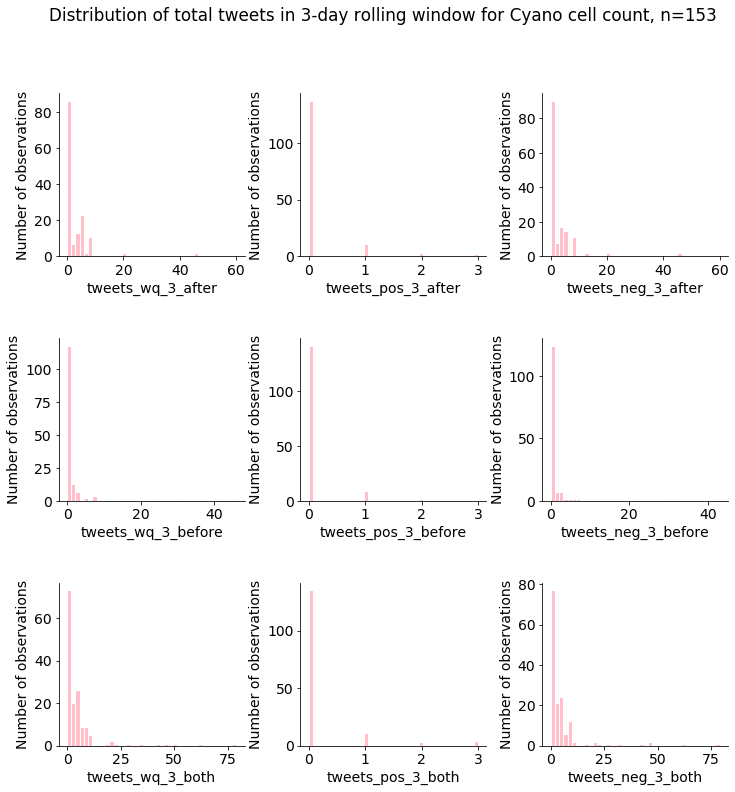

None

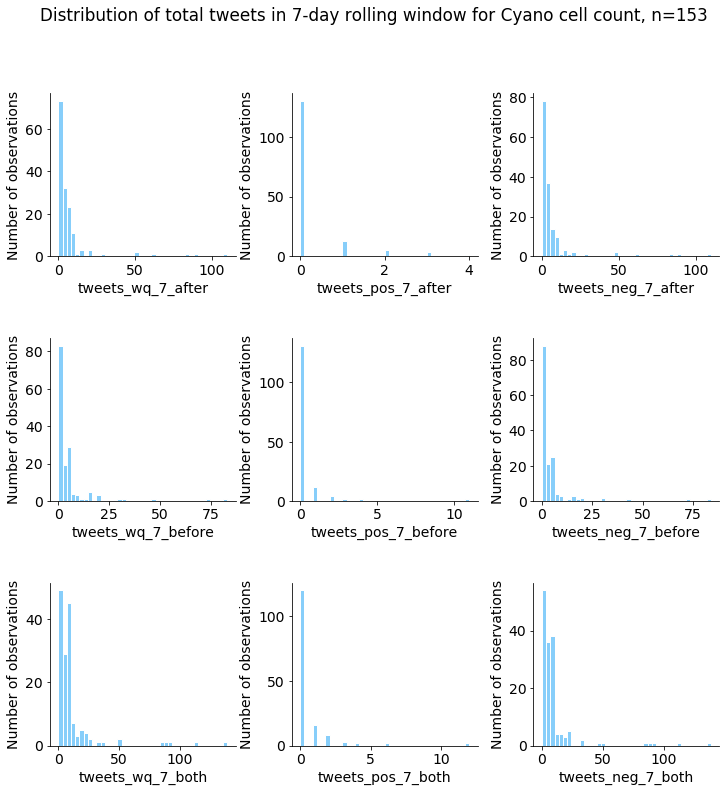

None

In [110]:
display(histogram_3days(df["ccc"], "Cyano cell count"));
display(histogram_7days(df["ccc"], "Cyano cell count"));

In [86]:
zero_inflated_poisson(df["sd"], "Secchi disk depth", "X75", "tweets_neg_3_both")

'Secchi disk depth'

Optimization terminated successfully.
         Current function value: 4.812086
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:       tweets_neg_3_both   No. Observations:                   38
Model:             ZeroInflatedPoisson   Df Residuals:                       36
Method:                            MLE   Df Model:                            1
Date:                 Mon, 01 Feb 2021   Pseudo R-squ.:                  0.2094
Time:                         12:09:06   Log-Likelihood:                -182.86
converged:                        True   LL-Null:                       -231.30
Covariance Type:             nonrobust   LLR p-value:                 7.359e-23
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Intercept     0.2104      0.851      0.247      0.805      -1.458       1.879
inflate_X75          -2.8514      3.047     -0.936      0.349      -8.823       3.120
Intercept             3.7626      0.177     21.198      0.000       3.415       4.110
X75                  -6.4826      0.804     -8.068      0.000      -8.057      -4.908
=====================================================================================
"""

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



In [154]:
def f(x):
    return x
interact(f, x=[('oneeeeeeeeeeeeeeeeeeeeffffffffffddddddddddddddddddddddddd', '10'), ('two', 20)]);

interactive(children=(Dropdown(description='x', options=(('oneeeeeeeeeeeeeeeeeeeeffffffffffddddddddddddddddddd…

In [151]:
df['sd'].columns

Index(['OID', 'OBJECTID_1', 'COUNT', 'AREA', 'MEAN', 'STD', 'SUM', 'X25',
       'X50', 'X75', 'tweets_neg_3_both', 'tweets_pos_3_both',
       'tweets_wq_3_both', 'tweets_neg_3_before', 'tweets_pos_3_before',
       'tweets_wq_3_before', 'tweets_neg_3_after', 'tweets_pos_3_after',
       'tweets_wq_3_after', 'tweets_neg_7_both', 'tweets_pos_7_both',
       'tweets_wq_7_both', 'tweets_neg_7_before', 'tweets_pos_7_before',
       'tweets_wq_7_before', 'tweets_neg_7_after', 'tweets_pos_7_after',
       'tweets_wq_7_after'],
      dtype='object')

In [ ]:
df['sd'].columns

# Secchi disk depth

## Tweet distributions

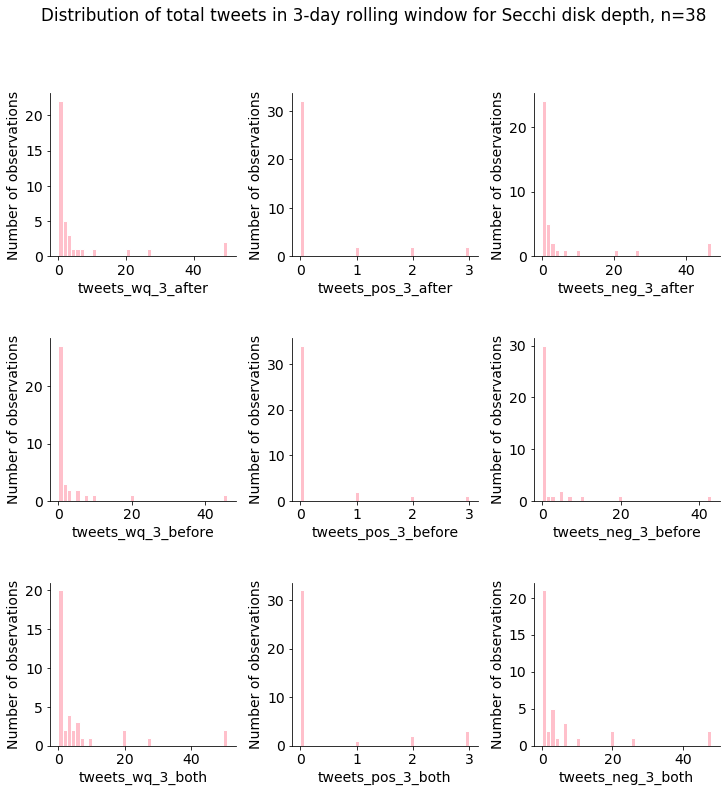

None

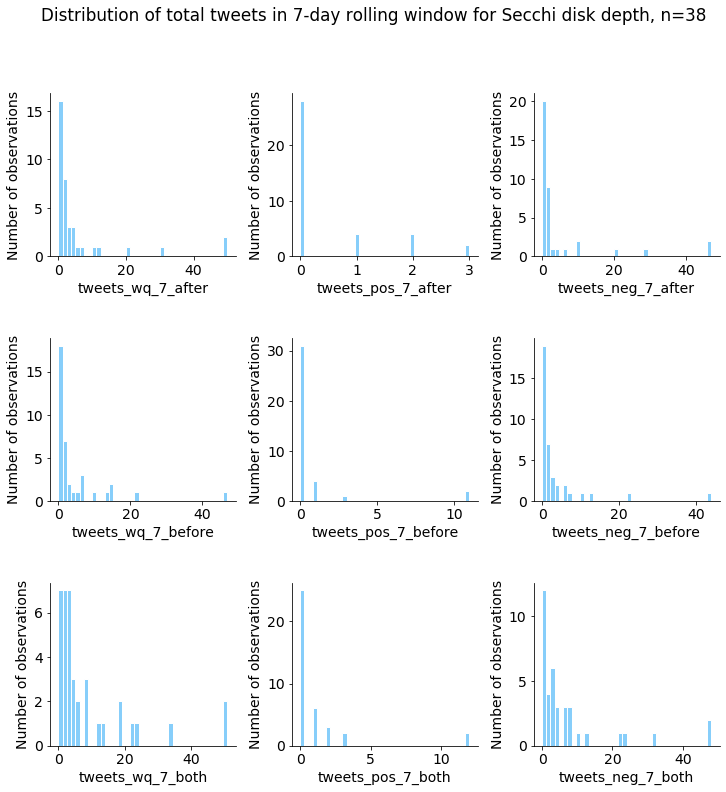

None

In [153]:
display(histogram_3days(df["sd"], "Secchi disk depth"));
display(histogram_7days(df["sd"], "Secchi disk depth"));

## Model

In [160]:
run_model()

interactive(children=(Dropdown(description='wq', options=(('Secchi disk depth', 'sd'), ('Chlorophyll', 'c'), (…

In [ ]:
names = ["c", "cb", "ccc", "sd", "tb", "tcc", "tss", "t", "tweets"]

In [158]:
def poisson(wq, x, y):
    
    abc = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, abc, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p.summary()

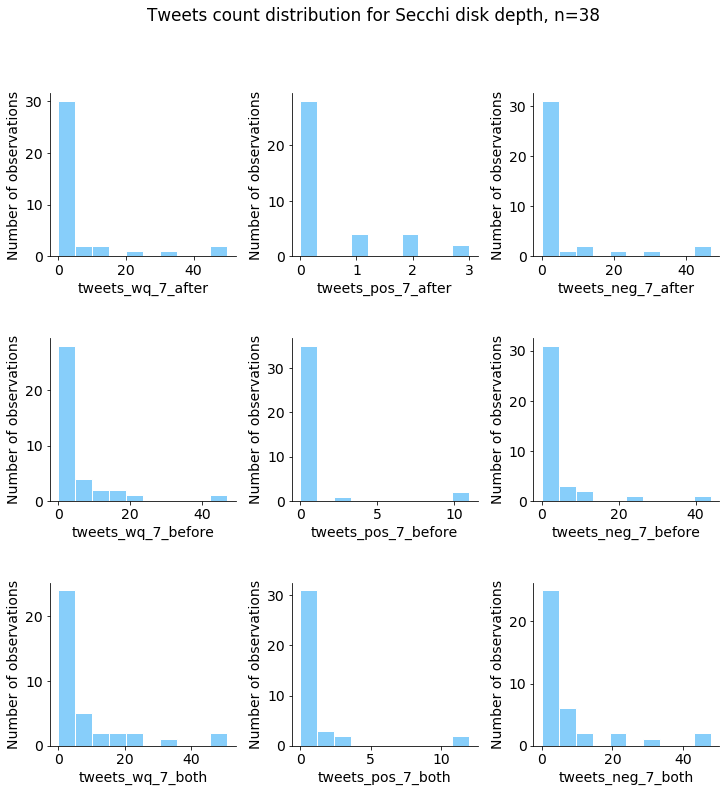

In [125]:
# Create histogram

fig = plt.figure(figsize=(12,12))
i = -1

for num in range(1,10):

    ax1 = fig.add_subplot(3,3,num)
    ax1.hist(sd.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white")
    ax1.set(xlabel = sd.columns[i], ylabel=f'Number of observations')
    i-=1

fig.suptitle(f"Tweets count distribution for {Secchi disk depth}, n={len(sd)}")
#fig.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [ ]:
# Calculate mean and variance (NOPE DONT DO IT)
# Fit zero-inflated poisson regression
# Fit negative binomial regression and Zero-inflated binomial regression (see why? in below link)
# Create residual vs fitter plots for both

In [ ]:
# example of doing poisson and negative 
# https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/

# we might not always need zero inflated model
# https://statisticalhorizons.com/zero-inflated-models

In [140]:
df['sd']

,OID,OBJECTID_1,COUNT,AREA,MEAN,STD,SUM,X25.,X50.,X75.,...,tweets_wq_3_after,tweets_neg_7_both,tweets_pos_7_both,tweets_wq_7_both,tweets_neg_7_before,tweets_pos_7_before,tweets_wq_7_before,tweets_neg_7_after,tweets_pos_7_after,tweets_wq_7_after
0,0,2016-04-20,27254.0,0.036135,0.326584,6.522402e-02,8900.717586,0.292608,0.326837,0.379791,...,1.0,3.0,1.0,4.0,2.0,1.0,3.0,1.0,0.0,1.0
1,1,2016-05-25,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0
2,2,2016-06-30,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
3,3,2017-05-10,27254.0,0.036135,0.266793,1.052118e-02,7271.177156,0.256585,0.267754,0.272464,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
4,4,2017-05-11,27254.0,0.036135,0.271572,1.186248e-02,7401.413938,0.265434,0.269956,0.278423,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
5,5,2017-06-15,27254.0,0.036135,0.321752,4.414198e-02,8769.025205,0.300185,0.308336,0.364803,...,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0
6,6,2017-07-11,27254.0,0.036135,0.214709,3.412158e-02,5851.680627,0.201629,0.212833,0.237013,...,27.0,32.0,0.0,34.0,3.0,0.0,5.0,29.0,0.0,30.0
7,7,2017-08-07,27254.0,0.036135,0.289606,3.882226e-02,7892.927859,0.274076,0.288600,0.306758,...,3.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,2.0,5.0
8,8,2017-08-08,27254.0,0.036135,0.265372,3.149683e-02,7232.436012,0.249463,0.263379,0.284706,...,4.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,1.0,4.0
9,9,2017-09-11,27254.0,0.036135,0.290509,3.197386e-02,7917.524259,0.275228,0.296750,0.305719,...,1.0,3.0,0.0,3.0,1.0,0.0,1.0,2.0,0.0,2.0


In [9]:
# Import explanatory and response variables data
tweets = pd.read_csv("../../data/processed/regression/tweets_daily_final.csv")
sd = pd.read_csv("../../data/processed/regression/secchi_depth_final.csv")
t = pd.read_csv("../../data/processed/regression/turbidity_final.csv")
tss = pd.read_csv("../../data/processed/regression/total_suspended_solids_final.csv")
c = pd.read_csv("../../data/processed/regression/chlorophyll_final.csv")
tcc = pd.read_csv("../../data/processed/regression/total_cell_count_final.csv")
tb = pd.read_csv("../../data/processed/regression/total_biovolume_final.csv")
ccc = pd.read_csv("../../data/processed/regression/cyano_cell_count_final.csv")
cb = pd.read_csv("../../data/processed/regression/cyano_biovolume_final.csv")


In [10]:
# convert date column to datetime object
tweets['time'] = pd.to_datetime(tweets['time'])
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])
t['OBJECTID_1'] = pd.to_datetime(t['OBJECTID_1'])
tss['OBJECTID_1'] = pd.to_datetime(tss['OBJECTID_1'])
c['OBJECTID_1'] = pd.to_datetime(c['OBJECTID_1'])
tcc['OBJECTID_1'] = pd.to_datetime(tcc['OBJECTID_1'])
tb['OBJECTID_1'] = pd.to_datetime(tb['OBJECTID_1'])
ccc['OBJECTID_1'] = pd.to_datetime(ccc['OBJECTID_1'])
cb['OBJECTID_1'] = pd.to_datetime(cb['OBJECTID_1'])

In [12]:
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])

In [13]:
sd['OBJECTID_1'][0] 

Timestamp('2016-04-20 00:00:00')

In [15]:
idx = tweets['time'].eq(sd['OBJECTID_1'][0]).idxmax()
res = tweets.iloc[idx-7: idx+1]

print(res)

          time  water quality?  neg  pos
103 2016-04-13             0.0  0.0  0.0
104 2016-04-14             3.0  2.0  1.0
105 2016-04-15             0.0  0.0  0.0
106 2016-04-16             0.0  0.0  0.0
107 2016-04-17             0.0  0.0  0.0
108 2016-04-18             0.0  0.0  0.0
109 2016-04-19             0.0  0.0  0.0
110 2016-04-20             0.0  0.0  0.0


In [16]:
# create new columns to store tweet counts data

sd['tweets_neg_3_both'] = np.nan
sd['tweets_pos_3_both'] = np.nan
sd['tweets_wq_3_both']  = np.nan 

sd['tweets_neg_3_before'] = np.nan
sd['tweets_pos_3_before'] = np.nan
sd['tweets_wq_3_before']  = np.nan 

sd['tweets_neg_3_after'] = np.nan
sd['tweets_pos_3_after'] = np.nan
sd['tweets_wq_3_after']  = np.nan


sd['tweets_neg_7_both'] = np.nan
sd['tweets_pos_7_both'] = np.nan
sd['tweets_wq_7_both']  = np.nan

sd['tweets_neg_7_before'] = np.nan
sd['tweets_pos_7_before'] = np.nan
sd['tweets_wq_7_before']  = np.nan

sd['tweets_neg_7_after'] = np.nan
sd['tweets_pos_7_after'] = np.nan
sd['tweets_wq_7_after']  = np.nan


# Iterate over each row in wq variable
for index, row in sd.iterrows():
    
    # get dates for which we have water quality measurements
    date_wq = row['OBJECTID_1']
    
    # get index of the row with same date in the tweets data
    tweets_index = tweets['time'].eq(date_wq).idxmax()
    
    # get tweets info from 3 & 7 days before and after the date on which water quality was measured
    tweets_result_3_both = tweets.iloc[tweets_index-3: tweets_index+4]
    tweets_result_3_before = tweets.iloc[tweets_index-3: tweets_index+1]
    tweets_result_3_after = tweets.iloc[tweets_index: tweets_index+4]
    
    tweets_result_7_both = tweets.iloc[tweets_index-7: tweets_index+8]
    tweets_result_7_before = tweets.iloc[tweets_index-7: tweets_index+1]
    tweets_result_7_after = tweets.iloc[tweets_index: tweets_index+8]
    
    # assign the sum of negative tweets
    sd.loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_both'] = tweets_result_3_both['pos'].sum()
    sd.loc[index, 'tweets_wq_3_both'] = tweets_result_3_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_before'] = tweets_result_3_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_before'] = tweets_result_3_before['pos'].sum()
    sd.loc[index, 'tweets_wq_3_before'] = tweets_result_3_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_after'] = tweets_result_3_after['pos'].sum()
    sd.loc[index, 'tweets_wq_3_after'] = tweets_result_3_after['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_both'] = tweets_result_7_both['pos'].sum()
    sd.loc[index, 'tweets_wq_7_both'] = tweets_result_7_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_before'] = tweets_result_7_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_before'] = tweets_result_7_before['pos'].sum()
    sd.loc[index, 'tweets_wq_7_before'] = tweets_result_7_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_after'] = tweets_result_7_after['pos'].sum()
    sd.loc[index, 'tweets_wq_7_after'] = tweets_result_7_after['water quality?'].sum()
    
    
#     print(date_wq)
#     print(tweets_result)

In [17]:
sd.head(50)

,OID,OBJECTID_1,COUNT,AREA,MEAN,STD,SUM,X25.,X50.,X75.,...,tweets_wq_3_after,tweets_neg_7_both,tweets_pos_7_both,tweets_wq_7_both,tweets_neg_7_before,tweets_pos_7_before,tweets_wq_7_before,tweets_neg_7_after,tweets_pos_7_after,tweets_wq_7_after
0,0,2016-04-20,27254.0,0.036135,0.326584,6.522402e-02,8900.717586,0.292608,0.326837,0.379791,...,1.0,3.0,1.0,4.0,2.0,1.0,3.0,1.0,0.0,1.0
1,1,2016-05-25,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0
2,2,2016-06-30,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
3,3,2017-05-10,27254.0,0.036135,0.266793,1.052118e-02,7271.177156,0.256585,0.267754,0.272464,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
4,4,2017-05-11,27254.0,0.036135,0.271572,1.186248e-02,7401.413938,0.265434,0.269956,0.278423,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
5,5,2017-06-15,27254.0,0.036135,0.321752,4.414198e-02,8769.025205,0.300185,0.308336,0.364803,...,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0
6,6,2017-07-11,27254.0,0.036135,0.214709,3.412158e-02,5851.680627,0.201629,0.212833,0.237013,...,27.0,32.0,0.0,34.0,3.0,0.0,5.0,29.0,0.0,30.0
7,7,2017-08-07,27254.0,0.036135,0.289606,3.882226e-02,7892.927859,0.274076,0.288600,0.306758,...,3.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,2.0,5.0
8,8,2017-08-08,27254.0,0.036135,0.265372,3.149683e-02,7232.436012,0.249463,0.263379,0.284706,...,4.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,1.0,4.0
9,9,2017-09-11,27254.0,0.036135,0.290509,3.197386e-02,7917.524259,0.275228,0.296750,0.305719,...,1.0,3.0,0.0,3.0,1.0,0.0,1.0,2.0,0.0,2.0


In [27]:
sd.columns = sd.columns.str.replace(".", "")

In [83]:
# Regression - Zero inflated poisson regression (zip)
formula = "tweets_neg_3_both ~ X75"

# Use Patsy package to carve out the X and y matrices for ZIP model 
y, x = dmatrices(formula, sd, return_type='dataframe')

In [84]:
# https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057
model_zip = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit() #Fit the model using maximum likelihood
model_zip.summary()

Optimization terminated successfully.
         Current function value: 4.812086
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:       tweets_neg_3_both   No. Observations:                   38
Model:             ZeroInflatedPoisson   Df Residuals:                       36
Method:                            MLE   Df Model:                            1
Date:                 Mon, 01 Feb 2021   Pseudo R-squ.:                  0.2094
Time:                         12:07:59   Log-Likelihood:                -182.86
converged:                        True   LL-Null:                       -231.30
Covariance Type:             nonrobust   LLR p-value:                 7.359e-23
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Intercept     0.2104      0.851      0.247      0.805      -1.458       1.879
inflate_X75          -2.8514      3.047     -0.936      0.349      -8.823       3.120
Intercept             3.7626      0.177     21.198      0.000       3.415       4.110
X75                  -6.4826      0.804     -8.068      0.000      -8.057      -4.908
=====================================================================================
"""

In [45]:
model.params

inflate_Intercept    0.142571
inflate_X75         -1.821641
Intercept            3.762716
X75                 -6.483317
dtype: float64

In [51]:
# Regression - Zero Inflated Negative Binomial
# explantion abt zero inflation https://stats.stackexchange.com/questions/77745/zero-inflated-negative-binomial/257900
model_zinb = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=x, exog_infl=x).fit()
model_zinb.summary()

         Current function value: nan
         Iterations: 25
         Function evaluations: 242
         Gradient evaluations: 242


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3003: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3040: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3003: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3040: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3044: RuntimeWarning: invalid value encountered in multiply
  a3 / a2 +
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3003: RuntimeWarning: invalid value 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomialP Regression Results                     
==============================================================================
Dep. Variable:      tweets_neg_3_both   No. Observations:                   38
Model:              NegativeBinomialP   Df Residuals:                       36
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                     nan
Time:                        11:07:12   Log-Likelihood:                    nan
converged:                      False   LL-Null:                       -96.029
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2434.7488        nan        nan        nan         nan         nan
X75         3.275e+04        nan        nan        nan         nan         nan
alpha       -6.04e+04        nan        nan        nan         nan         nan
==============================================================================
"""